## Wizualizacja danych: Projekt 2
## Jakie cechy dobrze różnicują firmy, które kontynuują działalność gospodarczą w okresie 12 miesięcy od tych, które działalności nie kontynuują?
[zmienna Target]
### Ewaluacja modelu LightGBM

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("fivethirtyeight")
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

import lightgbm as lgb
from lightgbm import LGBMClassifier

import sys; sys.path.insert(0, '..')
from utils import evaluate

RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)

In [130]:
SAMPLE = None

data = pd.read_csv("../data/ceidg_data_classif.csv")
if SAMPLE:
    data = data.sample(SAMPLE)
print(data.shape)
data.head()

(2401055, 30)


,RandomDate,MonthOfStartingOfTheBusiness,QuarterOfStartingOfTheBusiness,MainAddressVoivodeship,MainAddressCounty,MainAddressTERC,CorrespondenceAddressVoivodeship,CorrespondenceAddressCounty,CorrespondenceAddressTERC,MainAndCorrespondenceAreTheSame,...,ShareholderInOtherCompanies,PKDMainSection,PKDMainDivision,PKDMainGroup,PKDMainClass,NoOfUniquePKDSections,NoOfUniquePKDDivsions,NoOfUniquePKDGroups,NoOfUniquePKDClasses,Target
0,2018-03-26,May,2,MAZOWIECKIE,WARSZAWA,1465011.0,NaN,NaN,NaN,False,...,False,NaN,NaN,NaN,NaN,0,0,0,0,False
1,2018-01-10,June,2,MAZOWIECKIE,WARSZAWA,1465078.0,MAZOWIECKIE,WARSZAWA,1465078.0,True,...,False,M,71.0,711.0,7112.0,4,6,10,13,False
2,2018-03-23,June,2,MAZOWIECKIE,WARSZAWA,1465011.0,MAZOWIECKIE,WARSZAWA,1465011.0,True,...,False,C,14.0,141.0,1412.0,5,6,14,21,False
3,2018-02-13,April,2,MAZOWIECKIE,WARSZAWA,1465011.0,MAZOWIECKIE,WARSZAWA,1465011.0,True,...,False,G,46.0,461.0,4619.0,2,5,8,11,False
4,2018-03-06,December,4,MAZOWIECKIE,WARSZAWA,1465078.0,MAZOWIECKIE,WARSZAWA,1465078.0,True,...,False,C,11.0,110.0,1107.0,3,19,31,44,False


In [149]:
### DATA PREPROCESSING
categorical_variables = [
    "MonthOfStartingOfTheBusiness", 
    "MainAddressVoivodeship",
    "CorrespondenceAddressVoivodeship",
    "CorrespondenceAddressCounty",
    "PKDMainSection",
    "Sex"
]


for col in categorical_variables:
    data[col] = data[col].astype('category')

x_train, x_test, y_train, y_test = train_test_split(data.drop("Target", axis=1), data["Target"], random_state=RANDOM_SEED)
print("".format(y_train.mean(), y_test.mean()))
x_train.head()

,RandomDate,MonthOfStartingOfTheBusiness,QuarterOfStartingOfTheBusiness,MainAddressVoivodeship,MainAddressCounty,MainAddressTERC,CorrespondenceAddressVoivodeship,CorrespondenceAddressCounty,CorrespondenceAddressTERC,MainAndCorrespondenceAreTheSame,...,HasPolishCitizenship,ShareholderInOtherCompanies,PKDMainSection,PKDMainDivision,PKDMainGroup,PKDMainClass,NoOfUniquePKDSections,NoOfUniquePKDDivsions,NoOfUniquePKDGroups,NoOfUniquePKDClasses
1702917,2018-01-24,September,3,LUBELSKIE,łUKOWSKI,611052.0,LUBELSKIE,łUKOWSKI,611052.0,True,...,True,False,G,45.0,452.0,4520.0,1,1,1,1
1782339,2018-01-01,December,4,POMORSKIE,BYTOWSKI,2201032.0,POMORSKIE,GDAńSK,2261011.0,False,...,True,False,J,62.0,620.0,6201.0,6,8,8,12
1082429,2018-01-29,June,2,WIELKOPOLSKIE,LESZNO,3063011.0,WIELKOPOLSKIE,LESZCZYńSKI,3013052.0,False,...,True,False,M,71.0,711.0,7111.0,6,8,10,15
558957,2018-09-01,February,1,WIELKOPOLSKIE,MIęDZYCHODZKI,3014034.0,WIELKOPOLSKIE,MIęDZYCHODZKI,3014034.0,False,...,True,False,P,85.0,856.0,8560.0,2,2,2,2
2272383,2018-02-14,October,4,ŚLĄSKIE,KATOWICE,2469011.0,ŚLĄSKIE,KATOWICE,2469011.0,True,...,True,False,M,75.0,750.0,7500.0,1,1,1,1


In [150]:
model_columns = categorical_variables + numerical_variables
x_train = x_train[model_columns]
x_test = x_test[model_columns]

d_train = lgb.Dataset(x_train, label=y_train)
d_test = lgb.Dataset(x_test, label=y_test)

clf = LGBMClassifier(max_depth=100, n_estimators=1000)
clf.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=100,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Accuracy: 82.93
F-1 score: 0.0567


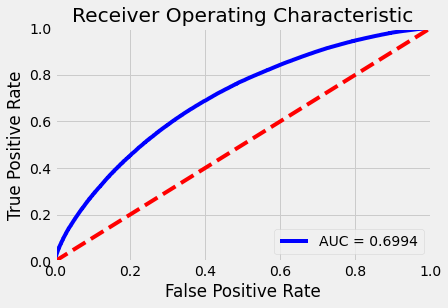

0.6994007301500436

In [151]:
evaluate(clf, x_test, y_test)

In [152]:
y_pred = clf.predict(x_test)
confusion_matrix(y_test, y_pred)

array([[494717,   2267],
       [100201,   3079]])

---
#### What features are important?

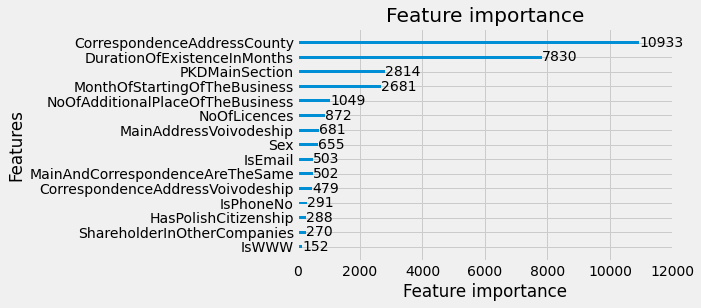

In [153]:
lgb.plot_importance(clf)